In [6]:
path = "Results/Masked/electricity_nhead_1_mask_1_options_all/electricity/"
# path = "aaai_Outputs_electricity_e336_d168_testprune_2_rp/electricity/"
# path = "Outputs_electricity_e336_d168_original_huber/electricity/"
#path = "Outputs_synthetic/foodinflation/"

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
preds = np.load(path+'trans-mse-ar_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
#preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
#trues = trues.reshape(-1, preds.shape[-2], preds.shape[-1])
# [samples, pred_len, dimensions]
print(preds.shape, trues.shape, inputs.shape)

print("mse : ",mean_squared_error(trues.squeeze(),preds.squeeze()),"mae: ",mean_absolute_error(trues.squeeze(),preds.squeeze()))

(54, 168, 1) (54, 168, 1) (54, 336, 1)
mse :  6635.095 mae:  57.86075


In [ ]:
plt.rcParams['figure.figsize'] = (12,4)
for i in range(54):
    plt.figure()
    c =i 
    x = np.arange(504)
    a = 336
    plt.plot(x[:a],inputs[c],label='input '+str(c))
    plt.plot(x[a:],trues[c,:,0], label='GroundTruth '+str(c))
    #for i in range(1):

    plt.plot(x[a:],preds[c,:,0], label='Prediction ')
    
    plt.legend()
    # fig = plt.figure()
    # plt.savefig("images/trans-mse_test_"+str(i)+".png")
    
    # plt.show()

In [7]:
preds_original = np.load("Results/march/Outputs/Output_original_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
preds_train = np.load("Results/march/Outputs/Output_synthetic_train_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
preds_test = np.load("Results/march/Outputs/Output_synthetic_test_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
preds_both = np.load("Results/march/Outputs/Output_synthetic_both_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
trues = np.load("Results/march/Outputs/Output_original_point_0.2_per/electricity/"+'targets.npy')


In [ ]:
print("original\t\ttrain\t\ttest\t\tboth")
for i in range(len(trues)):
    print(f"{mean_squared_error(trues.squeeze()[i,:],preds_original.squeeze())[i,:]:0.2f}, {mean_squared_error(trues.squeeze()[i,:],preds_train.squeeze()[i,:]):0.2f}, {mean_squared_error(trues.squeeze()[i,:],preds_test.squeeze()[i,:]):0.2f}, {mean_squared_error(trues.squeeze()[i,:],preds_both.squeeze()[i,:]):0.2f}")

In [3]:
import torch
ex_mask = torch.tensor([1,1,0,0,1],dtype=bool)
print(ex_mask)
# ex_mask = attn_mask.masked_fill(ex_mask==True,value=True)
# print(ex_mask)

tensor([ True,  True, False, False,  True])


In [ ]:
ex_mask = torch.tensor(ex_mask,dtype=bool)
head1 = ex_mask * ex_mask.unsqueeze(-1)
head2 = torch.zeros_like(head1)==1
ex = torch.stack((head1,head2))
# ex_mask = torch.tensor(ex,dtype=bool)
print(ex)

In [27]:
import numpy as np 
x= np.random.randn(3,5,13)
ds = np.array([np.repeat([[1,1,1,1]],5,axis=0),np.repeat([[2,2,2,2]],5,axis=0),np.repeat([[3,3,3,3]],5,axis=0)])

In [14]:
import pandas as pd 
import os
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(20,5)
DATA_DIRS = '/mnt/cat/data/sandy/Forecasting/'
df_inject   = pd.read_csv(
        os.path.join(DATA_DIRS, 'data', 'electricity_load_forecasting_panama', '2_percent_electricity.csv')
    )
data_mask = df_inject[['label']].to_numpy()
n = (1903 + 1) * 24 # Select first n=1904*24 entries because of non-stationarity in the data after first n values
data_mask = data_mask[:, :n]
N_output = 168
units = n//N_output
dev_len = int(0.2*units) * N_output
test_len = int(0.2*units) * N_output
train_len = n - dev_len - test_len

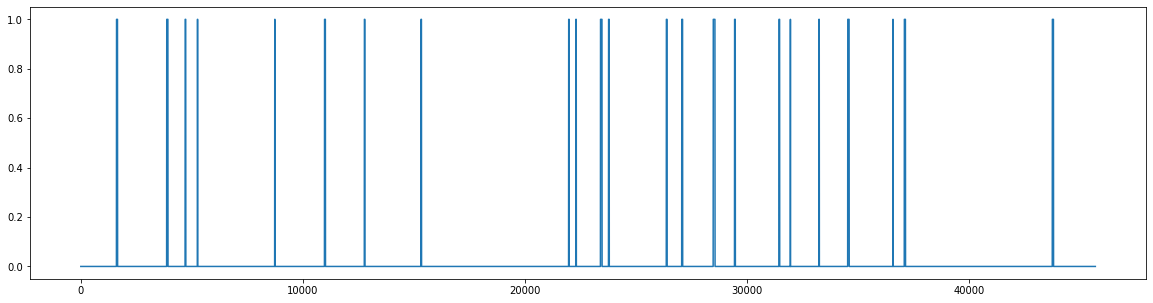

In [15]:
plt.plot(data_mask)

# data_mask.shape
